# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
snowball = SnowballStemmer(language='english')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as XGB
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
from numba import cuda
from nltk.tokenize import word_tokenize
import tensorflow_text as tftext
import tensorflow_hub as tfhub
import keras_nlp
import keras
from keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


# Loading the training CSV file

In [2]:
data = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv')
data

,text,label,source,fold
0,There are alot reasons to keep our the despise...,0,persuade_corpus,2
1,Driving smart cars that drive by themself has ...,0,persuade_corpus,4
2,"Dear Principal,\n\nI believe that students at ...",0,persuade_corpus,0
3,"Dear Principal,\n\nCommunity service should no...",0,persuade_corpus,0
4,My argument for the development of the driverl...,0,persuade_corpus,3
...,...,...,...,...
33254,Are driverless cars really necessary? Most of ...,0,persuade_corpus,4
33255,"""Oh man I didn't make the soccer team!"", yelle...",0,persuade_corpus,1
33256,I believe that using this technology could be ...,0,persuade_corpus,0
33257,Texting & Driving\n\nUsing your phone while dr...,0,persuade_corpus,3


In [3]:
data = data.drop(columns=['source','fold'])

label
0    25996
1     7263
Name: text, dtype: int64


([<matplotlib.patches.Wedge at 0x78a9f72e6650>,
 [Text(-0.8511286576207792, 0.6968357110371501, '0'),
  Text(0.8511286249995442, -0.6968357508813576, '1')],
 [Text(-0.4642519950658795, 0.38009220602026367, '78%'),
  Text(0.46425197727247863, -0.38009222775346774, '22%')])

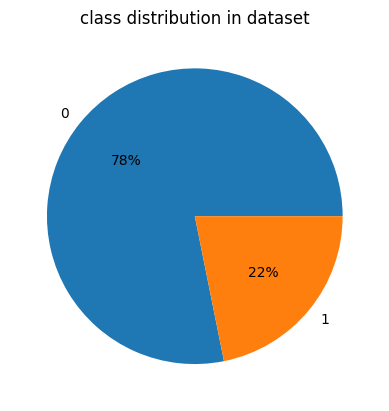

In [4]:
data_classes = data.groupby('label').count()['text']
print(data_classes)
plt.title('class distribution in dataset')
plt.pie(data_classes , labels = ['0','1'] ,autopct='%0.0f%%')

The dataset has class imbalance. So, taking first 7000 rows of class 0 to make a dataset of 14000 rows with equal class quantity

In [5]:
data_0 = data[data['label']==0].iloc[0:7263,:]
data_1 = data[data['label']==1]

In [6]:
final_data = pd.concat([data_0,data_1])
final_data

,text,label
0,There are alot reasons to keep our the despise...,0
1,Driving smart cars that drive by themself has ...,0
2,"Dear Principal,\n\nI believe that students at ...",0
3,"Dear Principal,\n\nCommunity service should no...",0
4,My argument for the development of the driverl...,0
...,...,...
33218,Despite some students' enthusiasm for a three-...,1
33230,Working in a group is way better than working ...,1
33234,The implementation of a four-day school week w...,1
33243,Thomas Jefferson was a prominent American stat...,1


([<matplotlib.patches.Wedge at 0x78a9f718b580>,
 [Text(6.735557395310444e-17, 1.1, '0'),
  Text(-2.0206672185931328e-16, -1.1, '1')],
 [Text(3.6739403974420595e-17, 0.6, '50%'),
  Text(-1.1021821192326178e-16, -0.6, '50%')])

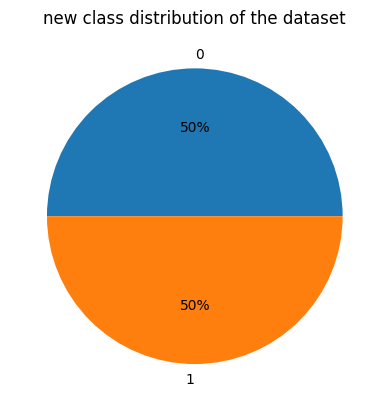

In [7]:
plt.title('new class distribution of the dataset')
plt.pie(final_data.groupby('label').count()['text'],labels=['0','1'],autopct='%0.0f%%')

Final dataset is completed and ready to work on

In [8]:
final_data['text'].index = np.arange(0,final_data.shape[0])
final_data['text']

0        There are alot reasons to keep our the despise...
1        Driving smart cars that drive by themself has ...
2        Dear Principal,\n\nI believe that students at ...
3        Dear Principal,\n\nCommunity service should no...
4        My argument for the development of the driverl...
                               ...                        
14521    Despite some students' enthusiasm for a three-...
14522    Working in a group is way better than working ...
14523    The implementation of a four-day school week w...
14524    Thomas Jefferson was a prominent American stat...
14525    Sure thing! Here's my attempt at writing an es...
Name: text, Length: 14526, dtype: object

In [9]:
def cleantext(data) :
    stemtext = []
    len_text = []
    para = data['text'].tolist()
    for paragraph in para:
        char = [char for char in paragraph if char not in string.punctuation]
        word = "".join(char).split(" ")
        words = [word.lower() for word in word if word not in stopwords.words('english')]
        stemwords = [SnowballStemmer('english').stem(word) for word in words]
        stemtext.append(" ".join(stemwords))  
        len_text.append(len(stemwords))
    return stemtext , len_text

In [10]:
traintext = cleantext(final_data)[0]

In [11]:
lentext = cleantext(final_data)[1]

In [12]:
len_df = pd.DataFrame(lentext)
len_df.describe()

,0
count,14526.000000
mean,202.284180
std,201.847709
min,4.000000
25%,141.000000
50%,190.000000
75%,229.000000
max,14681.000000


In [13]:
print("Average length of essays after cleaning the dataset is " , np.mean(lentext))

Average length of essays after cleaning the dataset is  202.28418009087153


In [14]:
print('Maximum length of an essay after cleaning the dataset is ' , np.max(lentext))

Maximum length of an essay after cleaning the dataset is  14681


A few essays were too long (even 14000 words), so removed the long paragraphs as 75% of essays were below 229 words length. So, kept only the essays shorter than 500 words length.

# Splitting the dataset into train and test

In [16]:
x_train, x_test ,y_train , y_test = train_test_split(final_data.iloc[:,0:2], final_data['label'],test_size=0.2)

In [26]:
len_train = []

for i in range(x_train.shape[0]):
    len_train.append(len(x_train.iloc[i,0]))
print('average characters per essay are ' , np.mean(len_train))

average characters per essay are  2064.112822719449


In [28]:
print('Average length of words including space is ' , np.mean(len_train)/np.mean(lentext))

Average length of words including space is  10.204024960291969


Average length of 10.2 is quite high !

In [39]:
x_train.groupby('label').count()

,text
label,
0,5797
1,5823


training data is balanced

# Preprocessing and fitting dataset in BERT model

In [45]:
preprocessor1 = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en_uncased",
    sequence_length=512,
)

classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_en_uncased",
    num_classes=1,
)

classifier.backbone.trainable = False

classifier.compile(
    loss=['binary_crossentropy'],
    optimizer=keras.optimizers.Adam(1e-4),
    jit_compile=True,
    metrics = ['accuracy','AUC']
)


classifier.fit(x= x_train['text'].to_list(), y=x_train['label'], batch_size=8 ,epochs =2,
               validation_data = (x_test['text'].to_list(),x_test['label']))

Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/1' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/1' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/1' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/1' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/1' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/1' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/1' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/1' to your Kaggle notebook...


Epoch 1/2
1453/1453 [==============================] - 273s 176ms/step - loss: 0.1201 - accuracy: 0.9619 - auc: 0.9936 - val_loss: 0.1761 - val_accuracy: 0.9597 - val_auc: 0.9926
Epoch 2/2
1453/1453 [==============================] - 238s 164ms/step - loss: 0.0565 - accuracy: 0.9838 - auc: 0.9978 - val_loss: 0.1853 - val_accuracy: 0.9663 - val_auc: 0.9918


In [46]:
final_test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
final_test

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [47]:
def cleantest(data) :
    stemtext = []
    len_text = []
    para = data['text'].tolist()
    for paragraph in para:
        char = [char for char in paragraph if char not in string.punctuation]
        word = "".join(char).split(" ")
        words = [word.lower() for word in word if word not in stopwords.words('english')]
        stemwords = [SnowballStemmer('english').stem(word) for word in words]
        stemtext.append(" ".join(stemwords))  #removing paragraphs longer than 500 words 
        len_text.append(len(stemwords))
    return stemtext , len_text
test_text = cleantest(final_test)[0]

In [48]:
final_test['text'] = test_text

# Prediction

In [49]:
pred = classifier.predict(final_test['text'].to_list())
pred

1/1 [==============================] - 4s 4s/step


array([[0.42734414],
       [0.55782264],
       [0.5809422 ]], dtype=float32)

In [50]:
test_result = pred[:,0]
test_result

array([0.42734414, 0.55782264, 0.5809422 ], dtype=float32)

In [51]:
final_submission = pd.DataFrame(final_test['id'])
final_submission['generated'] = test_result
final_submission

,id,generated
0,0000aaaa,0.427344
1,1111bbbb,0.557823
2,2222cccc,0.580942


In [52]:
final_submission.to_csv('submission.csv', index=False)

Results :
* XGBoost default : 0.276
* XGBoost learning rate 0.01 : 0.357
* XGBoost learning rate 0.005 : 0.442
* XGBoost learning rate 0.005 n_estimators 150 : 0.363
* SVM default : 0.325
* Logistic regression : 0.283
* DistilBERT learning rate 0.0001 : 0.369
* BERT learning rate 0.0001 6600 rows : 0.643
* BERT learning rate 0.0001 10660 rows (duplicates removed) : 0.668
* BERT learning rate 0.0005 10660 rows : 0.758
* BERT learning rate 0.0007 11650 rows : 0.643
* BERT learning rate 0.0005 19000 rows : 0.499 (version 31)
* BERT learning rate 0.0005 DAIGT dataset : 0.484
* DistilBERT learning rate 0.0005 DAIGT dataset : 0.591